In [1]:
!pip install striprtf pymystem3 keybert

In [116]:
import base64
import json
from pathlib import Path
import re
import os
from string import punctuation
from collections import defaultdict
import random

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

from tqdm.notebook import tqdm

import requests

import matplotlib.pyplot as plt

from striprtf.striprtf import rtf_to_text

from pymystem3 import Mystem

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
rus_stopwords = stopwords.words('russian')
# with open('trash_words.csv', encoding='utf-8') as f:
#     rus_stopwords.extend(map(lambda x: x.strip(), f.readlines()))

rus_stopwords = set(rus_stopwords)

import pickle

from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
sent_embed_model = SentenceTransformer('cointegrated/LaBSE-en-ru')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder

subset_punctuation = ''.join(set(punctuation) - set('.,:;!?'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No sentence-transformers model found with name C:\Users\vladi/.cache\torch\sentence_transformers\cointegrated_LaBSE-en-ru. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\vladi/.cache\torch\sentence_transformers\cointegrated_LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from

In [78]:
DOC_PATH = './docs/'
ADDITIONAL_DOC_PATH = './additional_docs/'
JSON_PATH = './classes.json'

In [79]:
def get_full_RTFtext(filename):
    with open(filename) as infile:
        content = infile.read()
        text = rtf_to_text(content)

    return text

def get_text(filename):
    with open(filename, 'rb') as f:
        encoded = base64.b64encode(f.read())

    ext = Path(filename).suffix[1:]
    if ext == 'rtf':
        return get_full_RTFtext(filename)

    url = 'http://localhost:8080/textract'
    myobj = {
        'data': encoded.decode('utf-8'),
        'file_type': ext
    }

    x = requests.post(url, json = myobj)

    if x.status_code != 200:
        return None
        
    return json.loads(x.text)['text']

In [81]:
# def drop_names(my_string):
#     emb = NewsEmbedding()
#     ner_tagger = NewsNERTagger(emb)
#     segmenter = Segmenter()
#     doc = Doc(my_string)
#     doc.segment(segmenter)
#     doc.tag_ner(ner_tagger)

#     names = [org.text for org in doc.spans if org.type =='PER']
#     print(names)
#     for name in names:
#         my_string = my_string.replace(name, '')
#     return my_string


def normalize(text):
    mystem = Mystem()

    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if
              token not in [" ", '\n'] \
              ]
    text = ' '.join(tokens)
    return text


def preprocess(my_string, verbose=True, do_normalize=True, remove_punct=True, remove_stopwords=False):
    if verbose:
        print('-', end='')
    
    my_string = re.sub(r"http\S+", "", my_string)
    
    my_string = re.sub(r'(\!)(.*?)\.((png)|(jpg)|(jpeg))', "", my_string)
    my_string = re.sub(r'(\{color)(.*?)\}', "", my_string)
#     my_string = drop_names(my_string)

    if remove_punct:
        my_string = re.sub(r'.*?\!(.*)!.*', "", my_string)
    
    my_string = my_string.lower().strip()

    if remove_punct:
        my_string = re.sub(r'[^\w\s]', ' ', my_string)
    else:
        my_string = my_string.translate(str.maketrans({symb: '' for symb in subset_punctuation}))
    my_string = re.sub(r'\n', ' ', my_string)
    my_string = re.sub(r'[0-9]+', '', my_string)
    my_string = re.sub(r'  *', ' ', my_string)
    my_string = my_string.strip()
    if do_normalize:
        my_string = normalize(my_string)
    my_string = re.sub( r'  *', ' ', my_string)
    my_string = ' '.join([el for el in my_string.strip().split() if len(el) > 1])
    my_string = my_string.replace('_', '')
    if not remove_punct:
        my_string = re.sub(r'\.{2,}', ' ', my_string)
        my_string = re.sub( r'  *', ' ', my_string)
    
    if remove_stopwords:
        my_string = ' '.join(filter(lambda x: x not in rus_stopwords, my_string.split()))
    
    return my_string

In [82]:
def read(filepath):
    text = get_text(filepath).replace('\n', ' ')
    return text

In [9]:
filepath = 'docs/0b4be82b86eff410d69d1d6b5553d220.docx'
with open(filepath, 'rb') as f:
    encoded = base64.b64encode(f.read())
with open('sample.base64.txt', 'w', encoding='utf-8') as f:
    f.write(encoded.decode('utf-8'))

# Извлечение ключевых фраз

С помощью библиотеки KeyBERT были извлечены ключевые фразы из каждого текста, из них потом составлялся словарь tfidf.

In [58]:
def get_large_text_embedding(text, model=sent_embed_model, n_tokens=250, overlapping_size=20):
    parts = []
    i = 0
    tokens = text.split()
    while i < len(tokens):
        part = tokens[max(0, i):min(i - n_tokens, len(tokens))]
        i += n_tokens - overlapping_size
        parts.append(' '.join(part))
    text_embed = model.encode(parts).mean(axis=0)
    return text_embed

get_large_text_embedding(read('docs/cf89a65d4477656ec05262ae55bb6aaa.doc')).shape

(768,)

In [54]:
kw_model = KeyBERT(model=sent_embed_model)

In [137]:
sample_doc = preprocess(read('docs/cf89a65d4477656ec05262ae55bb6aaa.doc'), verbose=False, do_normalize=False, remove_punct=False)
kw = list(map(lambda x: x[0], 
         kw_model.extract_keywords(
            [sample_doc], 
            keyphrase_ngram_range=(1, 3), 
            doc_embeddings=[get_large_text_embedding(sample_doc)],
            diversity=0.7,
            use_mmr=True)))

In [ ]:
texts = []

for filename in tqdm(os.listdir(DOC_PATH)):
    try:
        text = preprocess(read(os.path.join(DOC_PATH, filename)), verbose=False, do_normalize=False, remove_punct=False)
        texts.append(text)
    except Exception:
        continue

with open('bert_processed_texts.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(texts))

In [ ]:
texts = []

for filename in tqdm(os.listdir(DOC_PATH)):
    try:
        text = preprocess(read(os.path.join(DOC_PATH, filename)), verbose=False, do_normalize=False, remove_punct=False)
        texts.append(text)
    except Exception:
        continue

for folder in tqdm(os.listdir(ADDITIONAL_DOC_PATH)):
    folder_path = os.path.join(ADDITIONAL_DOC_PATH, folder)
    for filename in tqdm(os.listdir(folder_path)):
        try:
            text = preprocess(read(os.path.join(folder_path, filename)), verbose=False, do_normalize=False, remove_punct=False)
            texts.append(text)
        except Exception:
            continue

with open('bert_processed_texts2.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(texts))

In [ ]:
texts = []
embeddings = []
keywords = []

with open('bert_processed_texts2.txt', encoding='utf-8') as f:
    texts = f.readlines()

for text in tqdm(texts):
    embeddings.append(get_large_text_embedding(text))

print('Embeddings calculated!')

embeddings = np.array(embeddings)

kw = kw_model.extract_keywords(
        texts, 
        keyphrase_ngram_range=(1, 1), 
        doc_embeddings=embeddings,
        diversity=0.7,
        use_mmr=True,
        top_n=75)

for k in kw:
    kw_ = list(map(lambda x: x[0], k))
    keywords.extend(kw_)

kw = kw_model.extract_keywords(
        texts, 
        keyphrase_ngram_range=(2, 2), 
        doc_embeddings=embeddings,
        diversity=0.7,
        use_mmr=True,
        top_n=100)

for k in kw:
    kw_ = list(map(lambda x: x[0], k))
    keywords.extend(kw_)

In [ ]:
with open('keyphrases2.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(keywords))

In [22]:
with open('keyphrases2.txt', encoding='utf-8') as f:
    keyphrases = f.readlines()

processed_keyphrases = preprocess(' ддд '.join(keyphrases)).split(' ддд ')

proc2orig = defaultdict(list)
for idx, keyph in enumerate(processed_keyphrases):
    proc2orig[keyph].append(keyphrases[idx])

-

# Предобработка текста

In [122]:
data = pd.read_csv('dataset_noise.csv')
data.dropna(inplace=True)
data

,filenames,text,label
0,17_10_2022g_Dogovor_Arendy_Komnaty_V_Obschezhi...,\n ДОГОВО...,Договоры для акселератора/Договоры аренды
1,1Obrazets-dogovora-kupli-prodazhi-garazha.doc,\n ДОГОВОР КУПЛИ-ПРОДАЖ...,Договоры для акселератора/Договоры купли-продажи
2,1_Dogovor_Kupli_Sokolnikova_Dol14_1-1_Akkred_v...,ДОГОВОР \n\nКУПЛИ-ПРОДАЖИ КВАРТИРЫ\n\n\n\nГо...,Договоры для акселератора/Договоры купли-продажи
3,2021_Leto_Prilozhenie_K_Dogovoru_O_Peredache_R...,Правила направления и нахождения детей в детск...,Шум
4,33_Dogovor-Oferta_Zhivoy_Zhenchiny.pdf,Договор-оферта живой Женчины\nДОГОВОР-ОФЕРТА\n...,Шум
...,...,...,...
225,f57fe87f15a6dee2b17e804421be63b5.pdf,Страница 1 из 8 \n \nДОГОВОР КУПЛИ -ПРОДАЖИ …...,Договоры для акселератора/Договоры купли-продажи
226,f6377999f8a5aa9a09b03e428ac93153.doc,ДОГОВОР г._____________________ ...,Договоры для акселератора/Договоры поставки
227,f8eabec67b770c384d84f9feb7e02543.doc,Приложение № 10ДОГОВОР № _______г. Москва ...,Договоры для акселератора/Договоры оказания услуг
228,f96c2a58215aa54aeb6713cbb457fad9.doc,ДОГОВОР № _______г. Москва ...,Договоры для акселератора/Договоры оказания услуг


In [124]:
data['text'] = data['text'].map(lambda x: preprocess(x, remove_stopwords=True))

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [125]:
data

,filenames,text,label
0,17_10_2022g_Dogovor_Arendy_Komnaty_V_Obschezhi...,договор аренда комната нижеподписавшийся индив...,Договоры для акселератора/Договоры аренды
1,1Obrazets-dogovora-kupli-prodazhi-garazha.doc,договор купля продажа гараж новосибирск ноябрь...,Договоры для акселератора/Договоры купли-продажи
2,1_Dogovor_Kupli_Sokolnikova_Dol14_1-1_Akkred_v...,договор купля продажа квартира город набережна...,Договоры для акселератора/Договоры купли-продажи
3,2021_Leto_Prilozhenie_K_Dogovoru_O_Peredache_R...,правило направление нахождение ребенок детский...,Шум
4,33_Dogovor-Oferta_Zhivoy_Zhenchiny.pdf,договор оферта живой женчина договор оферта жи...,Шум
...,...,...,...
225,f57fe87f15a6dee2b17e804421be63b5.pdf,страница договор купля продажа оборудование бы...,Договоры для акселератора/Договоры купли-продажи
226,f6377999f8a5aa9a09b03e428ac93153.doc,договор предприятие дальнейшемименовать постав...,Договоры для акселератора/Договоры поставки
227,f8eabec67b770c384d84f9feb7e02543.doc,приложение договор москва краткий полный наиме...,Договоры для акселератора/Договоры оказания услуг
228,f96c2a58215aa54aeb6713cbb457fad9.doc,договор москва краткий полный наименование име...,Договоры для акселератора/Договоры оказания услуг


In [126]:
le = LabelEncoder()

data['label_encoded'] = le.fit_transform(data['label'])

pickle.dump(le, open('LabelEncoder2.pkl', 'wb'))

In [128]:
data_relevant = data[['text', 'label_encoded']]
data_relevant

,text,label_encoded
0,договор аренда комната нижеподписавшийся индив...,0
1,договор купля продажа гараж новосибирск ноябрь...,1
2,договор купля продажа квартира город набережна...,1
3,правило направление нахождение ребенок детский...,5
4,договор оферта живой женчина договор оферта жи...,5
...,...,...
225,страница договор купля продажа оборудование бы...,1
226,договор предприятие дальнейшемименовать постав...,4
227,приложение договор москва краткий полный наиме...,2
228,договор москва краткий полный наименование име...,2


In [129]:
data['label'].value_counts()

Договоры для акселератора/Договоры оказания услуг    46
Договоры для акселератора/Договоры аренды            40
Договоры для акселератора/Договоры купли-продажи     37
Шум                                                  37
Договоры для акселератора/Договоры поставки          35
Договоры для акселератора/Договоры подряда           27
Name: label, dtype: int64

In [130]:
X_train, X_test, y_train, y_test = train_test_split(data_relevant.text, data_relevant.label_encoded, test_size=0.3)

In [132]:
tfidf = TfidfVectorizer(vocabulary=set(processed_keyphrases))
# tfidf = TfidfVectorizer(min_df=0.1, max_df=0.9, )

train_vecs = tfidf.fit_transform(X_train)
test_vecs = tfidf.transform(X_test)

In [133]:
pickle.dump(tfidf, open('tfidf2.pkl', 'wb'))

In [134]:
whole_dataset_vecs = tfidf.fit_transform(data_relevant.text)
whole_dataset_label = data_relevant.label_encoded.values

In [136]:
model = LogisticRegression()

model.fit(train_vecs, y_train)

LogisticRegression()

In [137]:
pickle.dump(model, open('logistic_model2.pkl', 'wb'))

In [138]:
predictions = model.predict(test_vecs)

In [139]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.93      1.00      0.96        13
           2       1.00      0.80      0.89        10
           3       1.00      0.86      0.92         7
           4       1.00      0.91      0.95        11
           5       0.75      0.92      0.83        13

    accuracy                           0.91        67
   macro avg       0.93      0.90      0.91        67
weighted avg       0.92      0.91      0.91        67



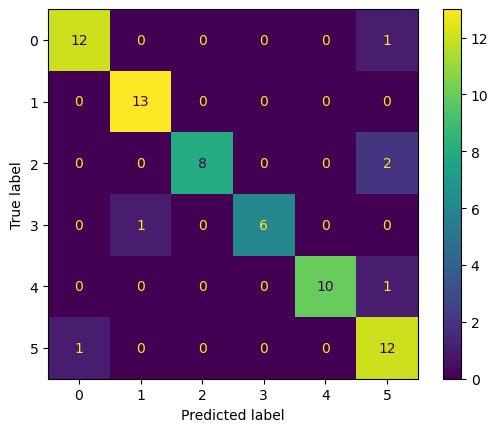

In [140]:
cm_norm = confusion_matrix(y_test, predictions)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp_norm.plot()
plt.show()

In [142]:
dt_clf = DecisionTreeClassifier(max_depth=5, criterion='entropy')
dt_clf.fit(train_vecs, y_train)

dt_predictions = dt_clf.predict(test_vecs)
print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79        13
           1       0.93      1.00      0.96        13
           2       1.00      0.40      0.57        10
           3       0.67      0.86      0.75         7
           4       0.77      0.91      0.83        11
           5       0.75      0.69      0.72        13

    accuracy                           0.79        67
   macro avg       0.81      0.78      0.77        67
weighted avg       0.81      0.79      0.78        67



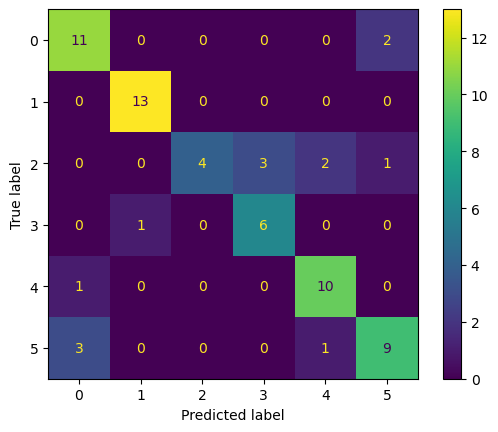

In [143]:
cm_norm = confusion_matrix(y_test, dt_predictions)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp_norm.plot()
plt.show()

In [144]:
from sklearn.model_selection import cross_val_score

In [145]:
print(cross_val_score(dt_clf, whole_dataset_vecs, whole_dataset_label, cv=5, scoring='f1_macro').mean())

0.8316059602592111


In [146]:
print(cross_val_score(model, whole_dataset_vecs, whole_dataset_label, cv=5, scoring='f1_macro').mean())

0.8781549060960826


# Интерпретация

In [148]:
class_ = 0
print(le.classes_[class_])

class0 = pd.DataFrame()
class0['phrases'] = tfidf.get_feature_names_out()
class0['coef'] = model.coef_[class_]
class0.sort_values(by='coef', ascending=False, inplace=True )
class0.reset_index(inplace=True, drop=True)
class0.head(10)

Договоры для акселератора/Договоры аренды


,phrases,coef
0,арендатор,2.070873
1,арендодатель,1.761203
2,аренда,0.966707
3,помещение,0.853408
4,наниматель,0.680105
5,наймодатель,0.538678
6,имущество,0.436756
7,плата,0.343806
8,предмет,0.341919
9,гараж,0.324985


In [183]:
with open('keyphrases2.txt', encoding='utf-8') as f:
    keyphrases = f.readlines()

processed_keyphrases = preprocess(' ддд '.join(keyphrases)).split(' ддд ')

proc2orig = defaultdict(list)
for idx, keyph in enumerate(processed_keyphrases):
    proc2orig[keyph].append(keyphrases[idx].strip())

def get_orig_from_processed(words, text):
    orig_words = []
    for word in words:
        for orig_word in proc2orig[word]:
            if orig_word in text:
                orig_words.append(orig_word)
                break
    return orig_words

def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def get_context_from_words(phrases, text, context_window=2):
    result = []
    tokens = text.split()
    for phrase in phrases:
        phrase_words = phrase.split()
        for idx, ngram in enumerate(find_ngrams(tokens, len(phrase_words))):
            if list(ngram) == phrase_words:
                span_begin = max(0, idx - context_window)
                span_end = min(len(tokens), idx + len(phrase_words) + context_window)
                result.append(' '.join(tokens[span_begin:span_end]))
    result = random.sample(result, k=min(10, len(result)))
    return result

def end2end(filepath):
    orig_text = read(filepath)
    text = preprocess(orig_text, verbose=False)
    vec = tfidf.transform([text])
    
    result = {}
    result['doc_id'] = Path(filepath).stem
    result['num_class'] = model.predict(vec)[0]
    result['text_class'] = le.classes_[result['num_class']]
    result['confidence'] = model.predict_proba(vec)[0, result['num_class']]
    

    nums = vec[0].toarray() * model.coef_[result['num_class']]
    top = np.argpartition(nums, -10)[:, -10:]

    proc_words = tfidf.get_feature_names_out()[top].reshape(-1).tolist()
    orig_words = get_orig_from_processed(proc_words, orig_text)
    result['top_words'] = ', '.join(orig_words)
    result['context_phrases'] = get_context_from_words(orig_words, orig_text)
    return result


-

In [184]:
filepath = 'docs/0b4be82b86eff410d69d1d6b5553d220.docx'
# filepath = 'docs/4a5707e447271a188a1211606b158a94.pdf'
result = end2end(filepath)

In [154]:
print(f"Уверенность: {(result['confidence'] * 100):0.2f}%\n")

Уверенность: 37.98%

